This first block of text simply contains all the libraries that need importing as well as initialsing some variables of this example. You may change the batch_size and epochs variables, but should not change num_classes, img_rows and img_cols as these depend on the dataset being used

In [1]:
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow.keras.datasets as datasets
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 256
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 32, 32

The next block of text handles all the data loading (in this case of the CIFAR-10 dataset) and reshaping so that it can be used to train and evaluate the CNN models. Two sets of data are loaded, the training data, used to generate the model, and the test data, used to evaluate if this model is good at making predictions

The final set of code of this cell defines the data augmentation pipeline, and it is commented by default

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test_orig = y_test
y_test = keras.utils.to_categorical(y_test, num_classes)

# Uncomment these lines to enable the data augmentation
#datagen = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(x_train)

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


This cell defines the CNN architecture. There are two versions of this code. The first one, identical to the practical defines layer by layer the architecture.

The second version loads a pre-defined architecture, that had been trained for a different problem. It removes the last layer (because that would be specific to the original problem, and adds some new layers. This process of adapting a network trained on a different problem is called *Transfer Learning*. 

The only essential new layer to add is the softmax one (last) that specifies the number of classes of the new dataset. You can play with this code by commenting or uncommenting some of the previous lines that add layers. 

Please note that the syntax used in here to define the network is different from the practical. We don't add layers to a stack with model.add, but chain each new layer to the previous one: "newLayer = NameOfNewLayer(arguments)(oldLayer)". In the code below variable x is used in place of both newLayer and oldLayer.

In [3]:
model = models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))\n",
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


#Comment the model above and uncomment the following lines to swithch to a pre-defined CNN architecture
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
# add a global spatial average pooling layer
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
#predictions = Dense(num_classes, activation='softmax')(x)
#model = models.Model(inputs=base_model.input, outputs=predictions)



# The rest of this cell is common to both defining the full architecture or using a pre-trained one
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,626,442
Trainable params: 1,626,442
Non-trainable params: 0
______________________________________________

This is the block of code that trains the model and evaluates its predictive capacity on the test data. There are two versions of the model.fit function, without and with image augmentation (defined in one of the cells above)

The evaluation code is more detailed that in the practical and has two parts. In the first part three performance metrics (precision, recall and F1) are computed for the examples of each of the 10 classes of the dataset, and then averaged. For the definition of these metrics, please see https://en.wikipedia.org/wiki/F-score.

The second part of the evaluation is what is called a confusion matrix. It is a matrix of size num_classes x num_classes, in which rows are asociated to the actual classes of the test set, and columns to the predicted classes. The number in each cell indicates the number of examples from the test set that belong to the class of the row, and have been predicted as the class of the column. Examples in the diagonal are correct classifications. Examples in the rest of the matrix are the misclassified ones. 

You will notice in the matrix that some columns have much bigger numbers than others. These means that the CNN model tends to predict the classes for these columns much more often than for the other columns, i.e. some classes are ignored.

Finally, a plot of how the loss function (measure of the training error of the network) changes through the epochs of training is shown.

Epoch 1/20
196/196 [==============================] - 36s 19ms/step - loss: 2.3097 - accuracy: 0.0927 - val_loss: 2.2929 - val_accuracy: 0.1216
Epoch 2/20
196/196 [==============================] - 3s 16ms/step - loss: 2.2894 - accuracy: 0.1331 - val_loss: 2.2800 - val_accuracy: 0.1464
Epoch 3/20
196/196 [==============================] - 3s 16ms/step - loss: 2.2765 - accuracy: 0.1490 - val_loss: 2.2684 - val_accuracy: 0.1628
Epoch 4/20
196/196 [==============================] - 3s 16ms/step - loss: 2.2646 - accuracy: 0.1672 - val_loss: 2.2552 - val_accuracy: 0.1691
Epoch 5/20
196/196 [==============================] - 3s 16ms/step - loss: 2.2516 - accuracy: 0.1780 - val_loss: 2.2422 - val_accuracy: 0.1819
Epoch 6/20
196/196 [==============================] - 3s 16ms/step - loss: 2.2382 - accuracy: 0.1893 - val_loss: 2.2285 - val_accuracy: 0.1937
Epoch 7/20
196/196 [==============================] - 3s 16ms/step - loss: 2.2238 - accuracy: 0.2006 - val_loss: 2.2147 - val_accuracy: 0.208

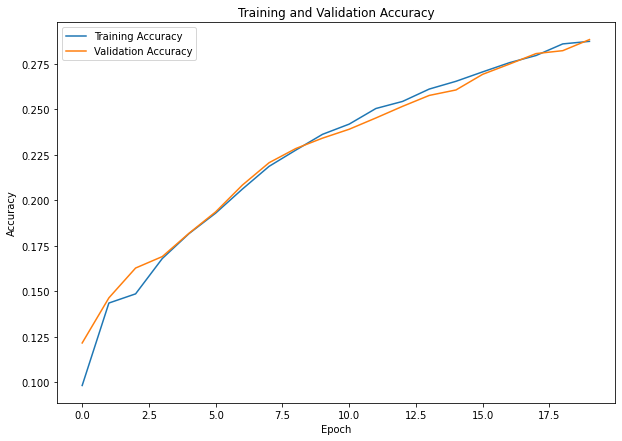

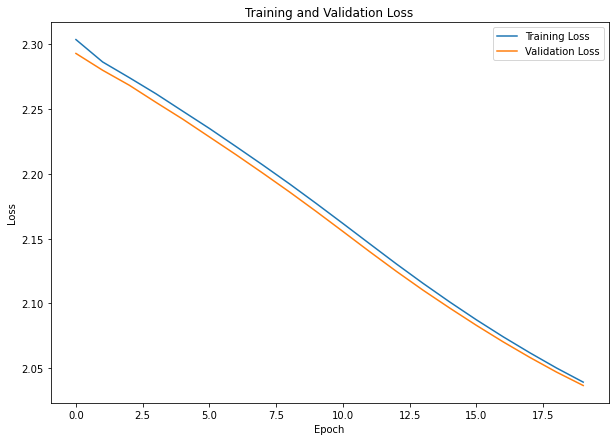

In [4]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          validation_data=(x_test, y_test),
          epochs=epochs,
          verbose=1)

# fits the model on batches with real-time data augmentation:
#history = model.fit(datagen.flow(x_train, y_train, 
#          batch_size=batch_size),
#          steps_per_epoch=len(x_train) / batch_size, 
#          epochs=epochs, 
#          verbose=1)

predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

print(metrics.classification_report(y_test_orig, predicted_classes))
print()
print(metrics.confusion_matrix(y_test_orig, predicted_classes))
print()

# Function for creating and displaying plot graph
def plot(attribute):
    plt.figure(figsize=(10,7))
    plt.plot(history.history[attribute.lower()], label='Training ' + attribute)
    plt.plot(history.history['val_' + attribute.lower()], label='Validation ' + attribute)
    plt.title('Training and Validation ' + attribute)
    plt.ylabel(attribute)
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('Basic-model-' + attribute.lower() + '.jpg', dpi=200)
    plt.show()

# Display accuracy and loss plot graphs
plot('Accuracy')
print()
plot('Loss')

This block of code picks an image from the test set (you can change the index to choose a different image), and shows the probabilities that the CNN model estimates for each class, then shows the actual image.

Probability for class 0: 0.09603603184223175
Probability for class 1: 0.10034225136041641
Probability for class 2: 0.10297334939241409
Probability for class 3: 0.09879330545663834
Probability for class 4: 0.06848374754190445
Probability for class 5: 0.08529999852180481
Probability for class 6: 0.06931465119123459
Probability for class 7: 0.11589644849300385
Probability for class 8: 0.10726071149110794
Probability for class 9: 0.15559953451156616

The winner is 9
The correct class is 5



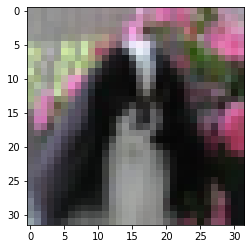

In [5]:
img_index = 42
image = x_test[img_index]

pred=model.predict(np.expand_dims(image, axis=0))[0]
for cl in range(num_classes):
        print("Probability for class {}: {}".format(cl,pred[cl]))
print("\nThe winner is {}".format(np.argmax(pred)))
print("The correct class is {}\n".format(np.argmax(y_test[img_index])))

plt.imshow(image.squeeze(),cmap='viridis')
plt.show()